# Prophet Python Baseline

In [1]:
# load packages
import pandas as pd
import numpy as np
from fbprophet import Prophet

import warnings

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# custom MAPE
def mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.nanmean(np.abs((y_true - y_pred) / y_true)) * 100

# custom MAE
def mae(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.nanmean(np.abs((y_true - y_pred)))

In [4]:
# read data
raw_data = pd.read_csv("../data/train.csv", parse_dates=["SHIFT_DATE"])

C:\Users\tung_\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (35) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
# split data to train and val
train = raw_data[(raw_data["SHIFT_DATE"]>"2012-12-31") & (raw_data["SHIFT_DATE"]<"2017-01-01")]
val = raw_data[(raw_data["SHIFT_DATE"]>"2016-12-31") & (raw_data["SHIFT_DATE"]<"2018-01-01")]

# Method 1

In [6]:
# using only a portion of the sites
small_train = train[(train["SITE"]=="St Paul's Hospital") | 
                    (train["SITE"]=="Mt St Joseph") | 
                    (train["SITE"]=="Holy Family") | 
                    (train["SITE"]=="SVH Langara") | 
                    (train["SITE"]=="Brock Fahrni") | 
                    (train["SITE"]=="Youville Residence")]

small_val = val[(val["SITE"]=="St Paul's Hospital") | 
                (val["SITE"]=="Mt St Joseph") | 
                (val["SITE"]=="Holy Family") | 
                (val["SITE"]=="SVH Langara") | 
                (val["SITE"]=="Brock Fahrni") | 
                (val["SITE"]=="Youville Residence")]

In [7]:
# create training dataframes
splitting_train = small_train.groupby(["JOB_FAMILY_DESCRIPTION", "SITE", "SHIFT_DATE"]).size().reset_index()
splitting_train = splitting_train.rename({"SHIFT_DATE":"ds", 0:"y"}, axis=1)

# create validation dataframes
splitting_val = small_val.groupby(["JOB_FAMILY_DESCRIPTION", "SITE", "SHIFT_DATE"]).size().reset_index()
splitting_val = splitting_val.rename({"SHIFT_DATE":"ds", 0:"y"}, axis=1)

In [8]:
# create timeframe data for prediction
timeframe = pd.DataFrame(pd.date_range(start='2017-01-01', end='2017-12-31', freq="D")).rename({0:"ds"}, axis=1)

In [79]:
def run_prophet(series, timeframe=timeframe):
    """
    Runs the Prophet 
    
    Key arguments:
    --------------
    series -- (DataFrame) time series data
    timeframe -- (DataFrame) a DataFrame with one column 
                 consisting of predicted dates

    Returns: 
    --------------
    Returns the forecast of the predictions 

    """
    model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False, 
                    # changepoint_prior_scale=0.001,
                    mcmc_samples=300,
                    interval_width=0.95)
    model.fit(series)
    forecast = model.predict(timeframe)
    return forecast

In [80]:
small_sites = small_train["SITE"].unique()
# small_las = small_train["JOB_FAMILY_DESCRIPTION"].unique()
small_jfs = ["Registered Nurse-DC1", "Registered Nurse-DC2A Sup", "Registered Nurse-DC2B"]

In [ ]:
warnings.simplefilter('ignore')
# create and store predictions and true results
split_data = {}
pred_results = {}
true_results = {}
for i in small_sites:
    for j in small_jfs:
        temp_data_train = splitting_train[(splitting_train["SITE"]==i) & (splitting_train["JOB_FAMILY_DESCRIPTION"]==j)].reset_index()
        temp_data_val = splitting_val[(splitting_val["SITE"]==i) & (splitting_val["JOB_FAMILY_DESCRIPTION"]==j)].reset_index(drop=True)
        split_data[(i, j)] = temp_data_train
        true_results[(i, j)] = temp_data_val
        try:
            pred_results[(i, j)] = run_prophet(temp_data_train)
            print("Fitting -", i, j, ": Done")
        except ValueError:
            pred_results[(i, j)] = None
            print("Fitting -", i, j, ": Failed")

In [66]:
# combine predictions and true results
combined = {}
for i in true_results:
    if pred_results[i] is not None:
        combined[i] = pd.merge(true_results[i], 
                               pred_results[i], 
                               on="ds", 
                               how="outer")[["ds", "y", "yhat", "yhat_lower", "yhat_upper"]]

In [67]:
# convert to week and calculating errors weekly
weekly = {}
for i in combined:
    # create week column
    combined[i]["week"] = combined[i]["ds"].dt.week
    combined[i]["ds"] = combined[i]["ds"]-pd.DateOffset(weekday=0, weeks=1)
    
    # store y, yhat, yhat_lower, yhat_upper
    weekly_y = combined[i].groupby("ds").y.sum().reset_index()
    weekly_yhat = combined[i].groupby("ds").yhat.sum().reset_index()
    weekly_yhat_lower = combined[i].groupby("ds").yhat_lower.sum().reset_index()
    weekly_yhat_upper = combined[i].groupby("ds").yhat_upper.sum().reset_index()
    
    # merge weekly results
    weekly[i] = pd.concat([weekly_y, weekly_yhat["yhat"], 
                           weekly_yhat_lower["yhat_lower"], 
                           weekly_yhat_upper["yhat_upper"]], 
                          axis=1)

    # create columns "year", "site", "job_family"
    length = weekly[i].shape[0]
    weekly[i]["week"] = weekly[i]["ds"].dt.weekofyear
    weekly[i]["site"] = np.repeat(i[0], length)
    weekly[i]["job_family"] = np.repeat(i[1], length)

In [68]:
for i in weekly:
    print("{}: MAPE: {}, MAE: {}".format(i, mape(weekly[i]["y"], weekly[i]["yhat"]), 
                                         mae(weekly[i]["y"], weekly[i]["yhat"])))

("St Paul's Hospital", 'Registered Nurse-DC1'): MAPE: 5.0693155235527945, MAE: 98.165632569631
("St Paul's Hospital", 'Registered Nurse-DC2A Sup'): MAPE: 29.71238565588476, MAE: 34.53677202628862
("St Paul's Hospital", 'Registered Nurse-DC2B'): MAPE: 27.26308912470625, MAE: 21.096911031769018
('Mt St Joseph', 'Registered Nurse-DC1'): MAPE: 13.221484497222963, MAE: 38.467065575904044
('Mt St Joseph', 'Registered Nurse-DC2A Sup'): MAPE: 52.84567048388428, MAE: 9.144475718704808
('Mt St Joseph', 'Registered Nurse-DC2B'): MAPE: inf, MAE: 6.841862495230874
('Youville Residence', 'Registered Nurse-DC1'): MAPE: 21.65193903968359, MAE: 8.150414617416974
('Youville Residence', 'Registered Nurse-DC2A Sup'): MAPE: inf, MAE: 5.101160144225855
('Youville Residence', 'Registered Nurse-DC2B'): MAPE: inf, MAE: 6.545537289867795
('SVH Langara', 'Registered Nurse-DC1'): MAPE: 29.904035223296894, MAE: 12.583775669446558
('SVH Langara', 'Registered Nurse-DC2A Sup'): MAPE: inf, MAE: 5.684422017574303
('SVH

## Aggregated

In [69]:
def aggregate_error(data, variable=None, method="mape"):
    """
    Given the combined data from our generated forecast and
    returns the aggregated error
    
    Key arguments:
    --------------
    data -- (dict) dictionary of data that we want to use
    variable -- (str) variable name
    method -- (str) mape or mae

    Returns: 
    --------------
    The aggregated MAPE or MAE of the forecast

    """
    test_pred = timeframe.copy()
    test_true = timeframe.copy()
    if variable is None:
        for i in data:
            test_pred = pd.merge(test_pred, data[i][["ds", "yhat"]], on="ds")
            test_true = pd.merge(test_true, data[i][["ds", "y"]], on="ds")
    else:
        for i in data:
            if variable in i:
                test_pred = pd.merge(test_pred, data[i][["ds", "yhat"]], on="ds")
                test_true = pd.merge(test_true, data[i][["ds", "y"]], on="ds")
    sum_pred = test_pred.sum(axis=1)
    sum_true = test_true.sum(axis=1)
    if method == "mape":
        return mape(sum_true, sum_pred)
    if method == "mae":
        return mae(sum_true, sum_pred)

In [70]:
# errors for each site
for i in small_sites:
    print("{}: MAPE: {}, MAE: {}".format(i, aggregate_error(weekly, i, "mape"), aggregate_error(weekly, i, "mae")))

St Paul's Hospital: MAPE: 4.369745614903153, MAE: 101.38481350332569
Mt St Joseph: MAPE: 12.291001826662253, MAE: 45.534409564979676
Youville Residence: MAPE: 34.76614458938122, MAE: 13.948997826050059
SVH Langara: MAPE: 49.29357635214357, MAE: 23.51543289601668
Brock Fahrni: MAPE: 40.96373161454362, MAE: 13.839266135934862
Holy Family: MAPE: 27.25142624275297, MAE: 18.290876501539632


In [71]:
# errors for each labor agreement
for i in small_jfs:
    print("{}: MAPE: {}, MAE: {}".format(i, aggregate_error(weekly, i, "mape"), aggregate_error(weekly, i, "mae")))

Registered Nurse-DC1: MAPE: 4.387966150001365, MAE: 114.7907206401632
Registered Nurse-DC2A Sup: MAPE: 37.02861576965646, MAE: 58.618303974537056
Registered Nurse-DC2B: MAPE: 17.84960987275085, MAE: 19.510735739497136


In [72]:
# total MAPE and MAE 
print("Total MAPE: {}\nTotal MAE: {}".format(aggregate_error(weekly, method="mape"), 
                                             aggregate_error(weekly, method="mae")))

Total MAPE: 4.554167673238677
Total MAE: 129.03663090687937


In [73]:
import plotly.plotly as py
import plotly.graph_objs as go

x = plot_data["ds"]
y = plot_data["y"]
yhat = plot_data["yhat"]
yhat_lower = plot_data["yhat_lower"]
yhat_upper = plot_data["yhat_upper"]

upper_bound = go.Scatter(
    name='Upper Bound',
    x=x,
    y=yhat_upper,
    mode='lines',
    line=dict(width=0.5, color="rgb(255, 255, 255)"),
    fillcolor='rgba(68, 68, 68, 0.1)',
    fill='tonexty',
    showlegend=False)

trace1 = go.Scatter(
    name='Actual',
    x=x,
    y=y,
    mode='lines',
    line=dict(color='rgb(31, 119, 180)'),)

trace2 = go.Scatter(
    name='Predictions',
    x=x,
    y=yhat,
    mode='lines',
    line=dict(color='rgb(246, 23, 26)'),)

lower_bound = go.Scatter(
    name='Lower Bound',
    x=x,
    y=yhat_lower,
    mode='lines',
    line=dict(width=0.5, color="rgb(255, 255, 255)"),
    showlegend=False)

data = [lower_bound, upper_bound, trace2, trace1]

py.iplot(data, filename='sample_plot')

Aw, snap! We didn't get a username with your request.

Don't have an account? https://plot.ly/api_signup

Questions? accounts@plot.ly


PlotlyError: Because you didn't supply a 'file_id' in the call, we're assuming you're trying to snag a figure from a url. You supplied the url, '', we expected it to start with 'https://plot.ly'.
Run help on this function for more information.

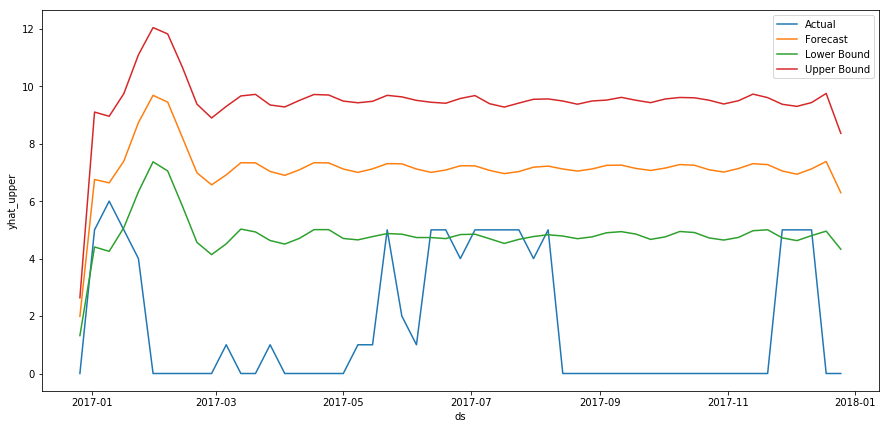

In [75]:
test = weekly[('Brock Fahrni', 'Registered Nurse-DC2B')]
test["ds"] = pd.to_datetime(test["ds"])
ax = plt.subplots(figsize=(15,7))
ax = sns.lineplot(data=test, x="ds", y="y", label="Actual")
ax = sns.lineplot(data=test, x="ds", y="yhat", label="Forecast")
ax = sns.lineplot(data=test, x="ds", y="yhat_lower", label="Lower Bound")
ax = sns.lineplot(data=test, x="ds", y="yhat_upper", label="Upper Bound")
# ax.fill_between(data=test, x="ds", y1='yhat_lower', y2='yhat_upper', color="orange", alpha=0.2)
# ax.fill_between(data=plot_data, x="ds", y1="yhat_lower", y2="yhat_upper", facecolor='blue', alpha=0.5)

In [ ]:
mcmc_samples=300

# Run below code to export tables

In [145]:
# # export to "data/predictions/" directory
# for i, j in weekly:
#     weekly[(i,j)].to_csv("../data/predictions/{}_{}.csv".format(i,j))

In [174]:
# Create all_data
total_data = pd.DataFrame()
for i in weekly:
    total_data = pd.concat([total_data, weekly[i]], axis=0)

In [177]:
# export total data
total_data.to_csv("../data/predictions/predictions.csv")

# Log

In [178]:
# create training dataframes
splitting_train = small_train.groupby(["JOB_FAMILY_DESCRIPTION", "SITE", "SHIFT_DATE"]).size().reset_index()
splitting_train = splitting_train.rename({"SHIFT_DATE":"ds", 0:"y"}, axis=1)
splitting_train["y"] = np.log(splitting_train["y"])

# create validation dataframes
splitting_val = small_val.groupby(["JOB_FAMILY_DESCRIPTION", "SITE", "SHIFT_DATE"]).size().reset_index()
splitting_val = splitting_val.rename({"SHIFT_DATE":"ds", 0:"y"}, axis=1)
splitting_val["y"] = np.log(splitting_val["y"])

In [180]:
warnings.simplefilter('ignore')
# create and store predictions and true results
split_data = {}
pred_results = {}
true_results = {}
for i in small_sites:
    for j in small_jfs:
        temp_data_train = splitting_train[(splitting_train["SITE"]==i) & (splitting_train["JOB_FAMILY_DESCRIPTION"]==j)].reset_index()
        temp_data_val = splitting_val[(splitting_val["SITE"]==i) & (splitting_val["JOB_FAMILY_DESCRIPTION"]==j)].reset_index(drop=True)
        split_data[(i, j)] = temp_data_train
        true_results[(i, j)] = temp_data_val
        try:
            pred_results[(i, j)] = run_prophet(temp_data_train)
            print("Fitting -", i, j, ": Done")
        except ValueError:
            pred_results[(i, j)] = None
            print("Fitting -", i, j, ": Failed")

Fitting - St Paul's Hospital Registered Nurse-DC1 : Done
Fitting - St Paul's Hospital Registered Nurse-DC2A Sup : Done
Fitting - St Paul's Hospital Registered Nurse-DC2B : Done
Fitting - Mt St Joseph Registered Nurse-DC1 : Done
Fitting - Mt St Joseph Registered Nurse-DC2A Sup : Done
Fitting - Mt St Joseph Registered Nurse-DC2B : Done
Fitting - Youville Residence Registered Nurse-DC1 : Done
Fitting - Youville Residence Registered Nurse-DC2A Sup : Done
Fitting - Youville Residence Registered Nurse-DC2B : Done
Fitting - SVH Langara Registered Nurse-DC1 : Done
Fitting - SVH Langara Registered Nurse-DC2A Sup : Done
Fitting - SVH Langara Registered Nurse-DC2B : Done
Fitting - Brock Fahrni Registered Nurse-DC1 : Done
Fitting - Brock Fahrni Registered Nurse-DC2A Sup : Done
Fitting - Brock Fahrni Registered Nurse-DC2B : Done
Fitting - Holy Family Registered Nurse-DC1 : Done
Fitting - Holy Family Registered Nurse-DC2A Sup : Done
Fitting - Holy Family Registered Nurse-DC2B : Done


In [181]:
# combine predictions and true results
combined = {}
for i in true_results:
    if pred_results[i] is not None:
        combined[i] = pd.merge(true_results[i], 
                               pred_results[i], 
                               on="ds", 
                               how="outer")[["ds", "y", "yhat", "yhat_lower", "yhat_upper"]]
        combined[i]["y"] = np.exp(combined[i]["y"])
        combined[i]["yhat"] = np.exp(combined[i]["yhat"])
        combined[i]["yhat_lower"] = np.exp(combined[i]["yhat_lower"])
        combined[i]["yhat_upper"] = np.exp(combined[i]["yhat_upper"])

In [182]:
# convert to week and calculating MAPE weekly
weekly = {}
for i in combined:
    # create week column
    combined[i]["week"] = combined[i]["ds"].dt.week
    combined[i]["ds"] = combined[i]["ds"]-pd.DateOffset(weekday=0, weeks=1)
    
    # store y, yhat, yhat_lower, yhat_upper
    weekly_y = combined[i].groupby("ds").y.sum().reset_index()
    weekly_yhat = combined[i].groupby("ds").yhat.sum().reset_index()
    weekly_yhat_lower = combined[i].groupby("ds").yhat_lower.sum().reset_index()
    weekly_yhat_upper = combined[i].groupby("ds").yhat_upper.sum().reset_index()
    
    # merge weekly results
    weekly[i] = pd.concat([weekly_y, weekly_yhat["yhat"], 
                           weekly_yhat_lower["yhat_lower"], 
                           weekly_yhat_upper["yhat_upper"]], 
                          axis=1)

    # create columns "year", "site", "job_family"
    length = weekly[i].shape[0]
    weekly[i]["week"] = weekly[i]["ds"].dt.weekofyear
    weekly[i]["site"] = np.repeat(i[0], length)
    weekly[i]["job_family"] = np.repeat(i[1], length)

In [183]:
for i in weekly:
    print("{}: MAPE: {}, MAE: {}".format(i, mape(weekly[i]["y"], weekly[i]["yhat"]), 
                                         mae(weekly[i]["y"], weekly[i]["yhat"])))

("St Paul's Hospital", 'Registered Nurse-DC1'): MAPE: 5.512551013684407, MAE: 109.55401795446514
("St Paul's Hospital", 'Registered Nurse-DC2A Sup'): MAPE: 27.943083630209824, MAE: 32.98984164252051
("St Paul's Hospital", 'Registered Nurse-DC2B'): MAPE: 21.218907905427276, MAE: 17.928620317606935
('Mt St Joseph', 'Registered Nurse-DC1'): MAPE: 11.168577366579292, MAE: 33.777793235903815
('Mt St Joseph', 'Registered Nurse-DC2A Sup'): MAPE: 40.4183882680099, MAE: 7.425298648910728
('Mt St Joseph', 'Registered Nurse-DC2B'): MAPE: inf, MAE: 5.334679386204028
('Youville Residence', 'Registered Nurse-DC1'): MAPE: 21.583042539151638, MAE: 9.54113737152036
('Youville Residence', 'Registered Nurse-DC2A Sup'): MAPE: inf, MAE: 5.240745311231194
('Youville Residence', 'Registered Nurse-DC2B'): MAPE: inf, MAE: 5.912485166037487
('SVH Langara', 'Registered Nurse-DC1'): MAPE: 19.98612848733887, MAE: 10.231121216901155
('SVH Langara', 'Registered Nurse-DC2A Sup'): MAPE: inf, MAE: 6.015164831737406
('S

# Imagine I am trying to see the accuracy for Nurses (among all SITEs)

In [184]:
# errors for each site
for i in small_sites:
    print("{}: MAPE: {}, MAE: {}".format(i, aggregate_error(weekly, i, "mape"), aggregate_error(weekly, i, "mae")))

St Paul's Hospital: MAPE: 4.924758029725802, MAE: 114.72688240142189
Mt St Joseph: MAPE: 9.859290451741284, MAE: 37.28136178073984
Youville Residence: MAPE: 19.53535531361171, MAE: 8.352665963171658
SVH Langara: MAPE: 26.219674570942665, MAE: 12.496797528626994
Brock Fahrni: MAPE: 26.411613650029402, MAE: 9.354038135799522
Holy Family: MAPE: 21.853833057653667, MAE: 15.670987196642471


In [185]:
# errors for each job family
for i in small_jfs:
    print("{}: MAPE: {}, MAE: {}".format(i, aggregate_error(weekly, i, "mape"), aggregate_error(weekly, i, "mae")))

Registered Nurse-DC1: MAPE: 5.351934201932985, MAE: 142.8731383398502
Registered Nurse-DC2A Sup: MAPE: 34.84778592619028, MAE: 55.358913953823894
Registered Nurse-DC2B: MAPE: 18.98501861194816, MAE: 20.195307874522225


In [186]:
# total MAPE and MAE 
print("Total MAPE: {}\nTotal MAE: {}".format(aggregate_error(weekly, method="mape"), 
                                             aggregate_error(weekly, method="mae")))

Total MAPE: 4.6263107468339015
Total MAE: 134.25149571047518


In [188]:
# Create all_data
total_data_log = pd.DataFrame()
for i in weekly:
    total_data_log = pd.concat([total_data, weekly[i]], axis=0)

In [191]:
total_data_log.to_csv("../data/predictions/predictions_log.csv")